## **Cat vs Dog Classification**
This notebook is based on the course **INFO6105 @ NEU**.  
[Link to Colab Notebook](https://colab.research.google.com/drive/14qpofloJSwikBrTSJFBoxtkh-WL0-HIV?usp=sharing)

---

### **Key Objectives**
1. **Understand the Cat vs Dog Dataset**: A binary classification task involving color images with three channels (RGB).
2. Perform experiments to optimize model performance by tuning architecture and hyperparameters.

---

### **Steps and Attempts**
#### **1. Data Preprocessing**
- **Objective**: Resize images to ensure uniformity in input dimensions.
- **Details**: Resized images from their original dimensions to 64x64 initially.
- **Reason**: Ensures compatibility with the model input layer and reduces computational requirements.

---

#### **2. Dropout Regularization**
- Introduced **dropout layers** to prevent overfitting.
- **How It Works**: Randomly sets a fraction of input units to zero during training.
- **Why It's Useful**: 
  - Reduces co-dependency among neurons.
  - Improves generalization performance on unseen data.

---

#### **3. Metric Selection**
- Opted to monitor **accuracy** over **loss** for early stopping.
- **Why**: Loss proved too sensitive in this case, leading to premature stopping. Accuracy provided a more stable indicator of model improvement.

---

#### **4. Early Stopping Callback**
- Added an **early stopping** mechanism based on validation accuracy.
- **How It Works**: Stops training if the validation accuracy does not improve for a defined number of epochs.
- **Benefits**:
  - Saves computational resources.
  - Prevents unnecessary overfitting during prolonged training.

---

### **Batch Size and Model Architecture**
#### **Batch Size Comparison**
- **Objective**: Determine the impact of batch sizes ranging from 8 to 512.
- **Usually**:
  - Smaller batches: Introduced gradient noise, helping escape local minima but requiring more updates.
  - Larger batches: Faster optimization steps but showed signs of overfitting.

- **But!From the result images below, patterns are not very clear**

<img src="https://github.com/zysea23/Markdown_Images/blob/main/A&L-batch=8_0.72.png?raw=true" alt="batch=8" width="700" height="300">
<img src="https://github.com/zysea23/Markdown_Images/blob/main/A&L-batch=16_0.74.png?raw=true" alt="batch=16" width="700" height="300">
<img src="https://github.com/zysea23/Markdown_Images/blob/main/A&L-batch=32_0.76.png?raw=true" alt="batch=32" width="700" height="300">
<img src="https://github.com/zysea23/Markdown_Images/blob/main/A&L-batch=64_0.766.png?raw=true" alt="batch=64" width="700" height="300">
<img src="https://github.com/zysea23/Markdown_Images/blob/main/A&L-batch=128_0.74.png?raw=true" alt="batch=128" width="700" height="300">
<img src="https://github.com/zysea23/Markdown_Images/blob/main/A&L-batch=256_0.71.png?raw=true" alt="batch=256" width="700" height="300">
<img src="https://github.com/zysea23/Markdown_Images/blob/main/A&L-batch=512_0.75.png?raw=true" alt="batch=512" width="700" height="300">



#### **Model Architecture Experiments**
- Experimented with **resize dimensions** (64x64 vs. 128x128):
  - Larger dimensions improved feature resolution **(not much!)** but increased computation time **(not much in this case too)**.

---

### **Summary**
The experiments in this notebook highlight:
- Increased the number of layers in the network to capture more complex features.
- The importance of preprocessing steps, such as **resizing** and **dropout**, for generalization.
- **Early stopping based on accuracy** provides a more robust criterion than loss in this case.
- Trade-offs in batch sizes and input dimensions must be balanced to achieve optimal performance.
- The final test set accuracy reached approximately 75%, likely reflecting the model's capacity and the limitations of the available training data, as no significant improvement was observed despite extensive parameter tuning.



Obtaining the dataset

The Dogs vs Cats dataset is available at https://www.kaggle.com/c/dogs-vs-cats/overview and consists of dogs and cats.

The full dataset constists 25,000 images. Here, we use a subset of the full dataset (containing only 2,000 images) to decrease training time.

We start with downloading the data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in /tmp/DogsVsCats.


In [761]:
# !mkdir -p /tmp/DogsVsCats
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#     -O /tmp/DogsVsCats/cats_and_dogs_filtered.zip

Extract the contents of the .zip to the base directory /tmp/DogsVsCats, which contains train and validation subdirectories for the training and validation datasets, which in turn each contain cats and dogs subdirectories.

In [762]:
# import os
# import zipfile

# local_zip = '/tmp/DogsVsCats/cats_and_dogs_filtered.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp/DogsVsCats/')
# zip_ref.close()

In [763]:
# !ls /tmp/DogsVsCats/cats_and_dogs_filtered/validation

The train and validation directories contain the training and validation datasets, which in turn each contain cats and dogs subdirectories. We put all cat and dog images into the same directory.

In [764]:
# !cp -a /tmp/DogsVsCats/cats_and_dogs_filtered/train/cats/. /tmp/DogsVsCats/train/
# !cp -a /tmp/DogsVsCats/cats_and_dogs_filtered/train/dogs/. /tmp/DogsVsCats/train/
# !cp -a /tmp/DogsVsCats/cats_and_dogs_filtered/validation/cats/. /tmp/DogsVsCats/test/
# !cp -a /tmp/DogsVsCats/cats_and_dogs_filtered/validation/dogs/. /tmp/DogsVsCats/test/

In [765]:
# check current directory
!pwd


/Users/peiyulin/Desktop/INFO6105_24Fall/Projects/CatsvsDogs


In [766]:
import os

train_data_dir = "tmp/DogsVsCats/train"
test_data_dir = "tmp/DogsVsCats/test"

train_imgs = os.listdir(train_data_dir)
test_imgs = os.listdir(test_data_dir)
print(len(train_imgs))
print(len(test_imgs))

2000
1000


In [767]:
import numpy as np
import pandas as pd
import os
#from scipy import ndimage #This package contains various functions for multi-dimensional image processing.
import cv2
import scipy
import matplotlib.pyplot as plt
import sys

num_px = 64

def extrcatFeaturesAndLabels(dir, impg_dataset):
  X = np.zeros((len(impg_dataset), num_px*num_px*3))
  y = np.zeros((len(impg_dataset)))
  for i in range(0,len(impg_dataset)) :
    #Read an image from a file as an array.
    #The different colour bands/channels are stored
    #in the third dimension, such that a
    #grey-image is MxN, an RGB-image MxNx3
    #image = np.array(ndimage.imread(dir + impg_dataset[i]))
    image = cv2.imread(os.path.join(dir, impg_dataset[i]))


    # Resize the image. Size of the output image (height, width)
    image = cv2.resize(image, (num_px, num_px))

    # Convert the matrix to a vector
    image = image.reshape((1, num_px*num_px*3)).T

    # Note that RGB (Red, Green, Blue) are 8 bit each.
    # Hence, the range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
    # By dividing by 255, Convert the 0-255 range to a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).
    image = image/255.0

    image = image.reshape((num_px*num_px*3,1))  # this step is to prevent the warning of data being 1D

    # for j in range(0,num_px*num_px*3):
    #     X[i][j] = image[j][0]

    # can be done in    
    X[i] = image.flatten()


    if 'dog' in impg_dataset[i]:
        y[i] = 0
    else :
        y[i] = 1

  y = y.astype(int)

  return(X, y)

def get_acuuracy(model, X, y):
  y_pred = model.predict(X)

  if sys.version_info < (3, 0):
      accuracy = ((np.sum(y == y_pred, axis=0)).astype('float') /
            X.shape[0])
  else:
      accuracy = np.sum(y == y_pred, axis=0) / X.shape[0]
      # accuracy = np.mean(y == y_pred) * 100

  #print('Accuracy: %.2f%%' % (accuracy * 100))

  return(accuracy * 100)

Training Data Set

Images can be represented as a matrix with number of elements equal to the number of pixels. However, color images are digitally represented as a volume (i.e., three-channels; or three matrices stacked on each other). The number three is used because colors are represented as red-green-blue (RGB) values. Here, we have a 64 × 64 × 3 image for each example and it is flattened into a single vector containing 12,288 elements.

In [768]:
from scipy import ndimage
train_X, train_Y = extrcatFeaturesAndLabels(train_data_dir, train_imgs)

### ✨Show first 5 images in training set

[[0.18823529 0.23137255 0.38039216 ... 0.63921569 0.65098039 0.6745098 ]
 [0.01960784 0.05490196 0.09019608 ... 0.2        0.24313725 0.2745098 ]
 [0.29803922 0.25882353 0.2627451  ... 0.15686275 0.24313725 0.32941176]
 [0.97647059 0.96078431 0.96078431 ... 0.38823529 0.34117647 0.41176471]
 [0.65490196 0.7372549  0.80392157 ... 0.98431373 0.99215686 0.99215686]]
[0 1 1 0 0]


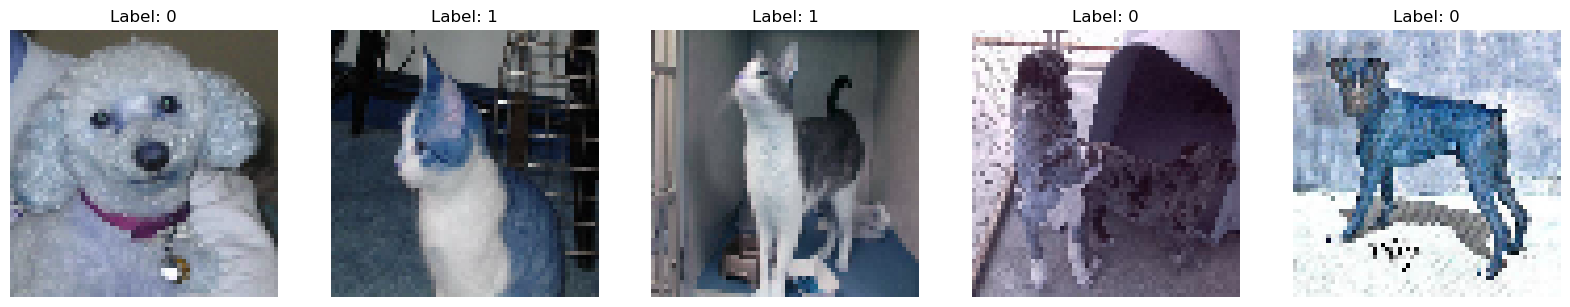

In [769]:
print(train_X[0:5])
print(train_Y[0:5])

#plot the first 5 images
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(train_X[i].reshape(num_px, num_px, 3))
    ax[i].set_title('Label: {}'.format(train_Y[i]))
    ax[i].axis('off')
plt.show()

In [770]:
test_X, test_Y = extrcatFeaturesAndLabels(test_data_dir, test_imgs)

In [771]:
print('Training Data set - Rows: %d, columns: %d' % (train_X.shape[0], train_X.shape[1]))
print('Test Data set - Rows: %d, columns: %d' % (test_X.shape[0], test_X.shape[1]))

Training Data set - Rows: 2000, columns: 12288
Test Data set - Rows: 1000, columns: 12288


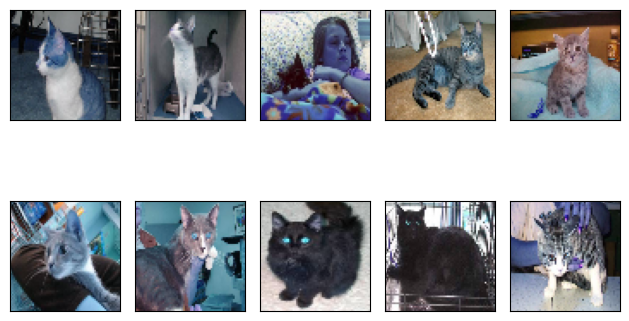

In [772]:
#10 different images of Cat:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = train_X[train_Y == 1][i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

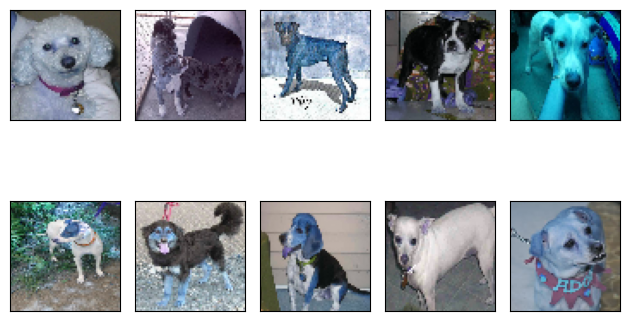

In [773]:
#10 different images of Dog:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = train_X[train_Y == 0][i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [774]:
print('Training data shape : ', train_X.shape, train_Y.shape) #print the shape of the training data using the train_X.shape, train_Y.shape functions.

print('Testing data shape : ', test_X.shape, test_Y.shape) #print the shape of the test data using the test_X.shape and test_Y.shape functions.

Training data shape :  (2000, 12288) (2000,)
Testing data shape :  (1000, 12288) (1000,)


In [775]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [776]:
train_X = train_X.reshape(-1, 64,64, 3) # convert each 64 x 64 x 3  image of the train datta into a matrix of size 64 x 64 x 3  which is fed into the network.
test_X = test_X.reshape(-1, 64,64, 3) #  # convert each 64 x 64 x 3  image of the train datta into a matrix of size 64 x 64 x 3  which is fed into the network.

print('Training data shape : ', train_X.shape, train_Y.shape) #print the shape of the training data using the train_X.shape, train_Y.shape functions.
print('Testing data shape : ', test_X.shape, test_Y.shape) #print the shape of the test data using the test_X.shape and test_Y.shape functions.


Training data shape :  (2000, 64, 64, 3) (2000,)
Testing data shape :  (1000, 64, 64, 3) (1000,)


In [777]:
# Change the labels from categorical to one-hot encoding
import keras
train_Y_one_hot = keras.utils.to_categorical(train_Y, 2)
test_Y_one_hot = keras.utils.to_categorical(test_Y, 2)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0.]


In [778]:
import keras
from keras.models import Sequential#,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


In [779]:
model = Sequential()#create a convolutional neural network (CNN) model for image classification.

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(64,64,3),padding='same')) #apply 32 filters of size 3*3.  The padding parameter is set to 'same', which means that the output size of the layer will be the same as the input size.
model.add(MaxPooling2D((2, 2),padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Dropout(0.5, input_shape=(2,)))   #Dropout is a regularization technique to prevent overfitting. It randomly sets a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax')) #num_classes = 2

In [780]:
model.summary(line_length=100)

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv2d_99 (Conv2D)                         │ (None, 64, 64, 32)              │               896 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_99 (MaxPooling2D)            │ (None, 32, 32, 32)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_100 (Conv2D)                        │ (None, 32, 32, 64)              │            18,496 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_100 (MaxPooling2D)           │ (None, 16, 16, 64)              │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv2d_101 (Conv2D)                        │ (None, 16, 16, 128)             │            73,856 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ max_pooling2d_101 (MaxPooling2D)           │ (None, 8, 8, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dropout_33 (Dropout)                       │ (None, 8, 8, 128)               │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ flatten_33 (Flatten)                       │ (None, 8192)                    │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_66 (Dense)                           │ (None, 128)                     │         1,048,704 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_67 (Dense)                           │ (None, 2)                       │               258 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 1,142,210 (4.36 MB)

 Trainable params: 1,142,210 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [781]:
#Compile the specified model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [782]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

#Split the data into a training set and a validation set
train_X_part, valid_X, train_label_part, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.1, random_state=42)

# print the shapes of the training and validation sets
print(f"train_X_part shape: {train_X_part.shape}, valid_X shape: {valid_X.shape}, train_label_part shape: {train_label_part.shape}, valid_label shape: {valid_label.shape}")



train_X_part shape: (1800, 64, 64, 3), valid_X shape: (200, 64, 64, 3), train_label_part shape: (1800, 2), valid_label shape: (200, 2)


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5013 - loss: 0.7076 - val_accuracy: 0.5400 - val_loss: 0.6838
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5757 - loss: 0.6799 - val_accuracy: 0.6050 - val_loss: 0.6589
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6356 - loss: 0.6487 - val_accuracy: 0.5750 - val_loss: 0.6605
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6454 - loss: 0.6270 - val_accuracy: 0.5600 - val_loss: 0.7049
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6897 - loss: 0.6041 - val_accuracy: 0.6150 - val_loss: 0.6707
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7383 - loss: 0.5486 - val_accuracy: 0.7050 - val_loss: 0.5709
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7606 - loss: 0.4926 - val_accuracy: 0.6950 - val_loss: 0.5813
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8072 - loss: 0.4357 - val_accuracy: 0.

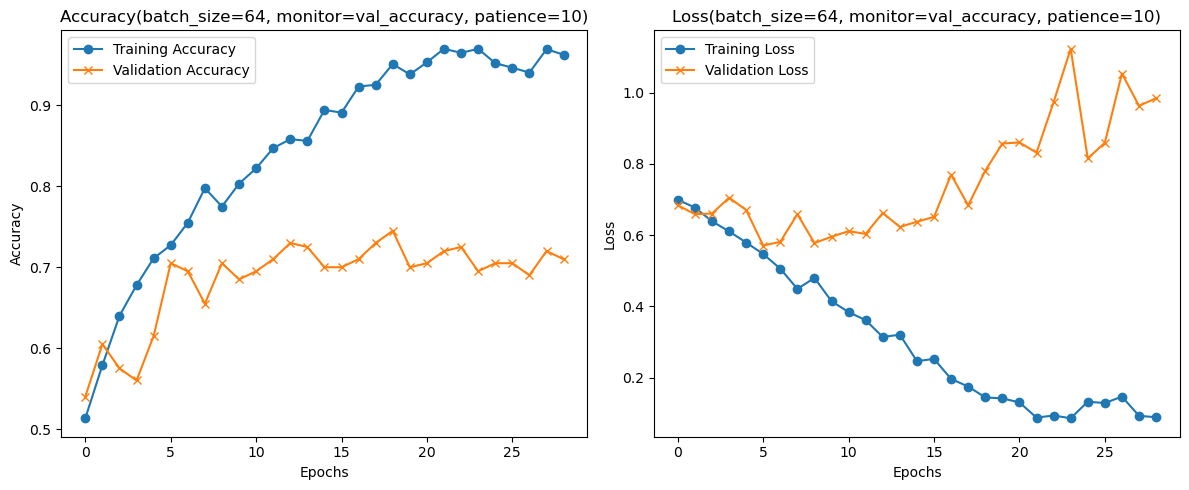

In [783]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=0)

# Define batch size and epochs
batch_size = 64
epochs = 100

# Train the model
history = model.fit(train_X_part, train_label_part, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(valid_X, valid_label), 
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=1)

# Plot training and validation accuracy/loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title(f'Accuracy(batch_size={batch_size}, monitor=val_accuracy, patience={early_stopping.patience})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title(f'Loss(batch_size={batch_size}, monitor=val_accuracy, patience={early_stopping.patience})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Question:
- How to choose best epoch number when training whole training set? There are no validation set for us to validate.
- - Use best epoch in initial training?

In [784]:
model.evaluate(test_X, test_Y_one_hot, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7543 - loss: 0.8519


[0.8328918218612671, 0.7519999742507935]

In [785]:
predicted_classes = model.predict(test_X)

print(predicted_classes[0:5])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[0.91614413 0.08385588]
 [0.18410331 0.81589675]
 [0.7669968  0.2330032 ]
 [0.33249798 0.667502  ]
 [0.00155786 0.9984421 ]]


Best epoch determined by early stopping: 29
Epoch 1/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4916 - loss: 0.7557Epoch 1 - Test Accuracy: 0.5000, Test Loss: 0.6910
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.4919 - loss: 0.7544
Epoch 2/29
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4984 - loss: 0.6909Epoch 2 - Test Accuracy: 0.5370, Test Loss: 0.6662
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5003 - loss: 0.6904
Epoch 3/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6140 - loss: 0.6587Epoch 3 - Test Accuracy: 0.6690, Test Loss: 0.6331
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6143 - loss: 0.6586
Epoch 4/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6472 - loss: 0.6234Epoch 4 - Test Accuracy: 0.6000, Test Loss: 0.6562
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6473 - loss: 0.6235
Epoch 5/29
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6871 - loss: 0.5983Epoch 5 - Test Accuracy: 0.7010, Tes

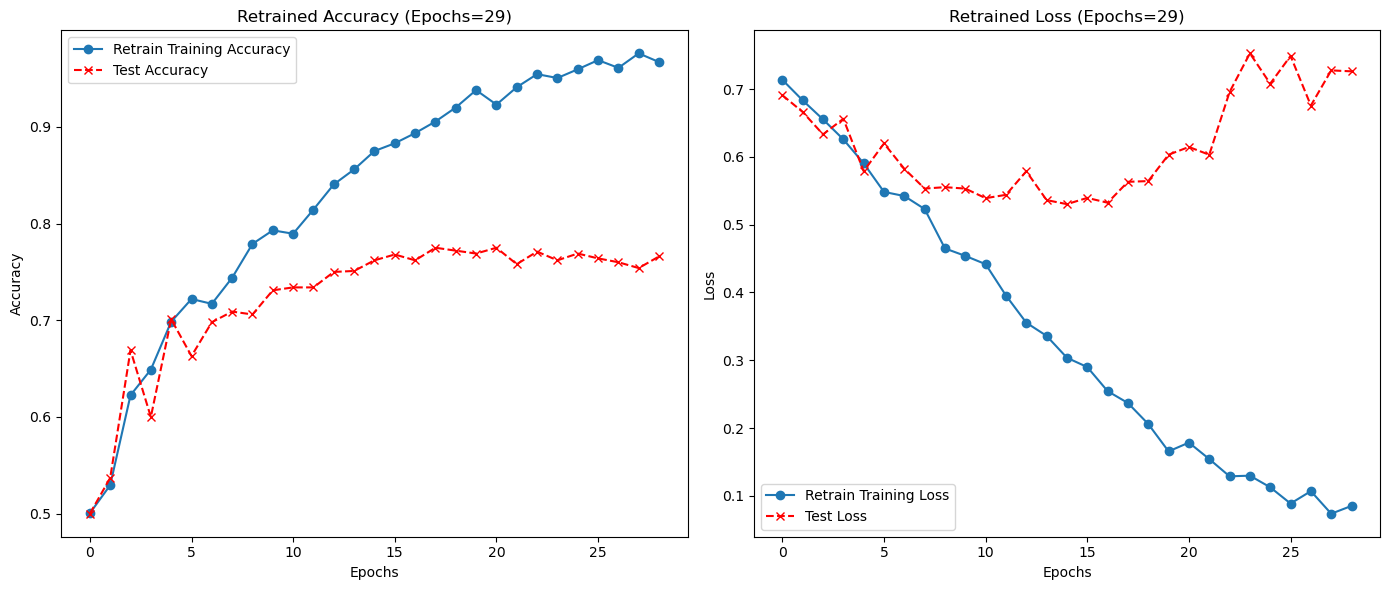

In [787]:
from keras.models import load_model, clone_model
from keras.callbacks import Callback
import matplotlib.pyplot as plt

# Load the previously saved best model
best_model = load_model('best_model.keras')

# Extract the number of epochs from the history of the previous training
best_epoch = len(history.history['accuracy'])
print(f"Best epoch determined by early stopping: {best_epoch}")

# Clone the best model to reinitialize weights
new_model = clone_model(best_model)
new_model.build(input_shape=(None, 64, 64, 3))  # Define input shape
new_model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])

# Define a custom callback to compute test accuracy and loss after each epoch
class TestAccuracyCallback(Callback):
    def __init__(self, test_X, test_Y):
        self.test_X = test_X
        self.test_Y = test_Y
        self.test_accuracies = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_accuracy = self.model.evaluate(self.test_X, self.test_Y, verbose=0)
        self.test_accuracies.append(test_accuracy)
        self.test_losses.append(test_loss)
        print(f"Epoch {epoch + 1} - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Instantiate the callback
test_callback = TestAccuracyCallback(test_X, test_Y_one_hot)

# Retrain the model on the entire training dataset using the best epoch number
history_retrain = new_model.fit(
    train_X, train_Y_one_hot,
    batch_size=batch_size,
    epochs=best_epoch,
    verbose=1,
    callbacks=[test_callback]
)

# Plot training and validation accuracy/loss curves along with test metrics
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_retrain.history['accuracy'], label='Retrain Training Accuracy', marker='o')
plt.plot(test_callback.test_accuracies, label='Test Accuracy', linestyle='--', color='r', marker='x')
plt.title(f'Retrained Accuracy (Epochs={best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_retrain.history['loss'], label='Retrain Training Loss', marker='o')
plt.plot(test_callback.test_losses, label='Test Loss', linestyle='--', color='r', marker='x')
plt.title(f'Retrained Loss (Epochs={best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7771 - loss: 0.6861
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[0 1 1 0 0]
[0 1 1 1 1]


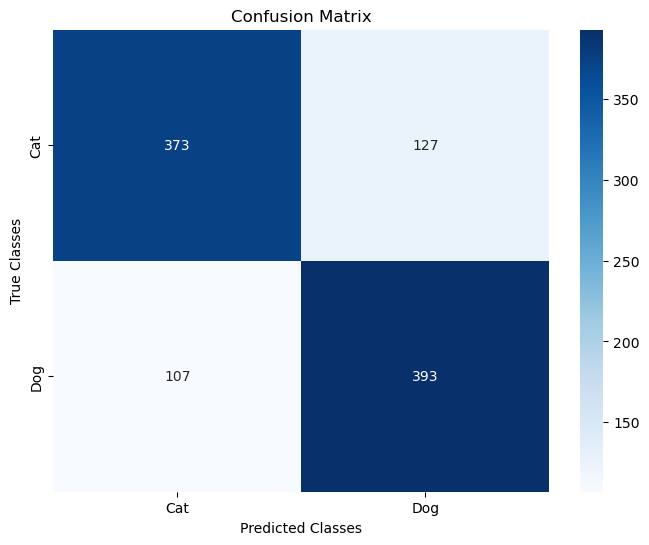

In [791]:
# metrics of the retrained model
new_model.evaluate(test_X, test_Y_one_hot, verbose=1)

# Predict the classes of the test set using the retrained model
predicted_classes_retrain = new_model.predict(test_X)

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert the one-hot encoded test labels to categorical
test_Y = np.argmax(test_Y_one_hot, axis=1)
print(test_Y[0:5])

# Convert the predicted classes to categorical
predicted_classes_retrain = np.argmax(predicted_classes_retrain, axis=1)
print(predicted_classes_retrain[0:5])

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_Y, predicted_classes_retrain)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()